# A short study on DA simulation time mitigation 

In accelerator physics, running Dynamics Aperture (DA) simulations is a time consuming task. Indeed, several parameters of the accelerator must be scanned, generally using a grid-search method. This approach, that one might qualify as 'brute force', involves simulating thousands of particles per Working Point (WP), with up to a million turns for each.

Massive parallelization allows to mitigate the process, as not only WP can be simulated in parallel, but also the particles of a given WP. This is a very efficient way to speed up the process, at the expense of a large number of cores. In practice, as we simulate 5 angle for each WP, we create jobs such that they correspond to a fifth of a WP (one job per angle), each with an homogeneous sampling of the amplitude particle distribution. 

This is a good strategy, but is often not enough when many variants of a given simulation must be run. For instance, a given tune-scan could be done for several filling schemes, chromaticities, emittances, etc. In this case, the number of WP to simulates can easily reach the thousands, corresponding to millions of particles. Consequently, the simulation can easily last several days, even when using a large number of cores (granted that they are available), and the simulation time quickly become a bottleneck in the analysis process.

In this notebook, we present three strategies to greatly accelerate the simulation process, by optimizing the total number of turns simulated to find the DA. The first strategy involves checking a given job every $n$ turns, and eliminate the particles which are not informative about DA anymore (in practice, this means the high-amplitude particles). The second strategy consists in doing the simulation in two steps: first simulating only part of the initial amplitude distribution, and then potentially simulating part of the remaining particles, if it's still needed to find the DA. Finally, the last strategy, which is also the simplest, consist in simulating the WP for a reduced number of turns (e.g. 100000), and only then simulating the remaining turns for the WP in which the DA will most likely be maximum. 

These three stategies are partially overlapping, but should still yield a significant speed-up when used together.

### Data loading (dummy simulation, run III 2024)

Load modules that will be useful for the analysis.

In [1]:
# Standard imports
import pandas as pd
import sys
import os
import seaborn as sns
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

# Local imports
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from tune_octupole import analysis_functions

# Apply better style
analysis_functions.apply_heatmap_style()

Load the study itself

In [2]:
# Define study
STUDY_NAME = "tune_scan_2024_angle"
COLLIDER = "collider_00"
PARQUET_PATH = f"../../scans/{STUDY_NAME}/da_complete.parquet"
CONF_MAD_PATH = f"../../scans/{STUDY_NAME}/{COLLIDER}/config.yaml"
CONF_COLLIDER_PATH = f"../../scans/{STUDY_NAME}/{COLLIDER}/xtrack_0005/config.yaml"

# Load dataframe
df_init = pd.read_parquet(PARQUET_PATH)

# Round all numbers to 3 decimals
df_init = df_init.round(3)
df_init

at_turn  state  \
beam  qx     qy     particle_id                     
lhcb1 62.305 60.305 0            1000000.0    1.0   
                    1            1000000.0    1.0   
                    2            1000000.0    1.0   
                    3            1000000.0    1.0   
                    4            1000000.0    1.0   
...                                    ...    ...   
      62.329 60.329 1275             271.0   -1.0   
                    1276             298.0   -1.0   
                    1277             320.0   -1.0   
                    1278            2013.0   -1.0   
                    1279             404.0   -1.0   

                                 normalized amplitude in xy-plane  \
beam  qx     qy     particle_id                                     
lhcb1 62.305 60.305 0                                       2.000   
                    1                                       2.031   
                    2                                       2.062   
                    3                                       2.094   
                    4                                       2.125   
...                                                           ...   
      62.329 60.329 1275                                    9.844   
                    1276                                    9.875   
                    1277                                    9.906   
                    1278                                    9.938   
                    1279                                    9.969   

                                 angle in xy-plane [deg]      qx      qy  \
beam  qx     qy     particle_id                                            
lhcb1 62.305 60.305 0                               15.0  62.305  60.305   
                    1                               15.0  62.305  60.305   
                    2                               15.0  62.305  60.305   
                    3                               15.0  62.305  60.305   
                    4                               15.0  62.305  60.305   
...                                                  ...     ...     ...   
      62.329 60.329 1275                            75.0  62.329  60.329   
                    1276                            75.0  62.329  60.329   
                    1277                            75.0  62.329  60.329   
                    1278                            75.0  62.329  60.329   
                    1279                            75.0  62.329  60.329   

                                 i_bunch_b1  i_bunch_b2  crossing_angle  
beam  qx     qy     particle_id                                          
lhcb1 62.305 60.305 0                 411.0       410.0           155.0  
                    1                 411.0       410.0           155.0  
                    2                 411.0       410.0           155.0  
                    3                 411.0       410.0           155.0  
                    4                 411.0       410.0           155.0  
...                                     ...         ...             ...  
      62.329 60.329 1275              411.0       410.0           155.0  
                    1276              411.0       410.0           155.0  
                    1277              411.0       410.0           155.0  
                    1278              411.0       410.0           155.0  
                    1279              411.0       410.0           155.0  

[409600 rows x 9 columns]

#### DA heatmap

Plot the usual DA heatmap for the study considered, to get an idea of the result we expect.

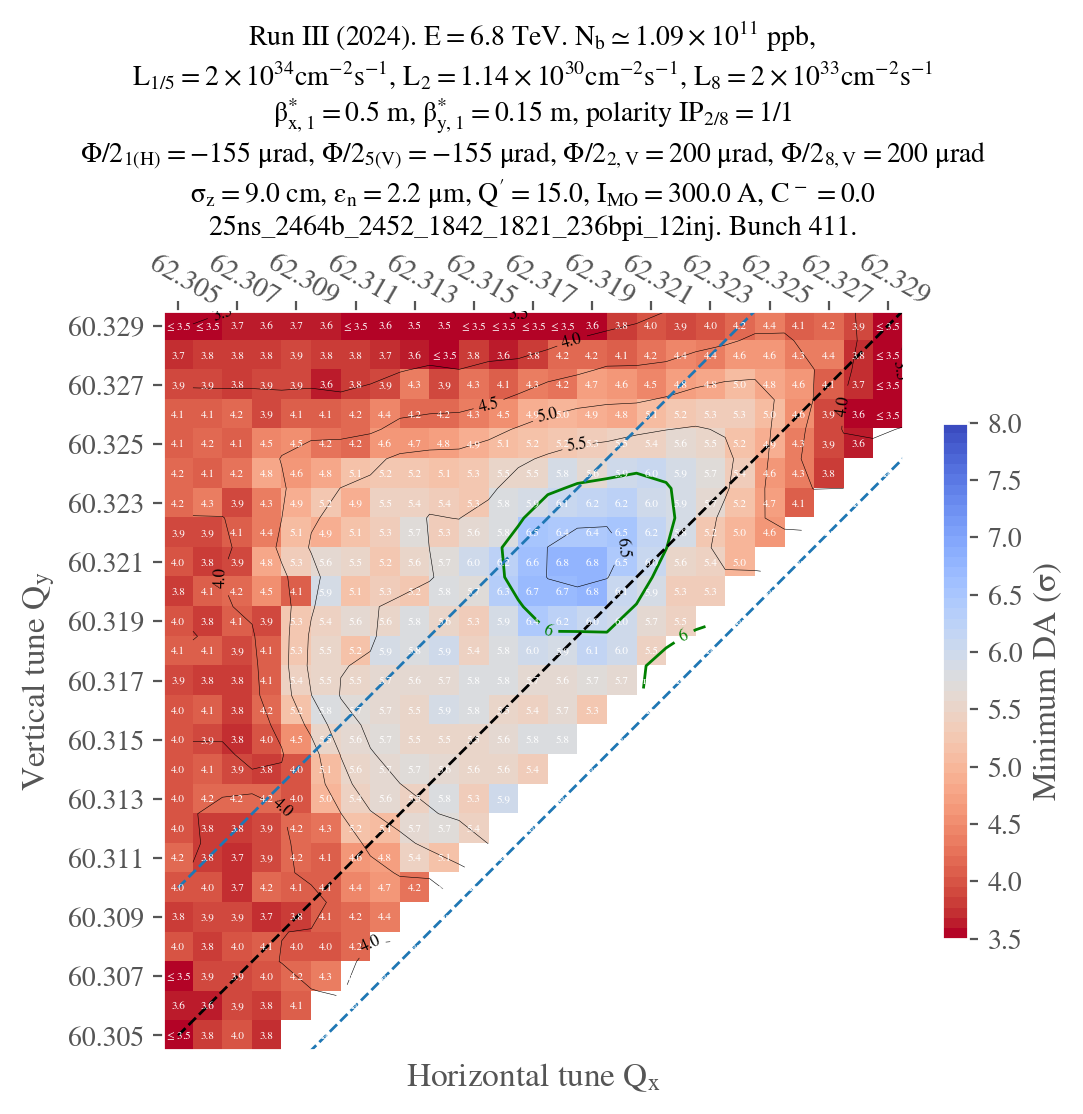

In [3]:
df_usual_plot = df_init[df_init["state"] == -1].reset_index(drop=True)


# Group by working point (Update this with the knobs you want to group by !)
group_by_parameters = ["qx", "qy"]

l_parameters_to_keep = [
    "normalized amplitude in xy-plane",
    "qx",
    "qy",
]

# Min is computed in the groupby function, but values should be identical
df_usual_plot = pd.DataFrame(
    [
        df_usual_plot.groupby(group_by_parameters)[parameter].min()
        for parameter in l_parameters_to_keep
    ]
).transpose()

# Reshape for plotting
df_to_plot = df_usual_plot.pivot(
    index="qy", columns="qx", values="normalized amplitude in xy-plane"
)
df_to_plot
# Load configuration files
conf_mad = analysis_functions.load_config(CONF_MAD_PATH)["config_mad"]
conf_collider = analysis_functions.load_config(CONF_COLLIDER_PATH)["config_collider"]
analysis_functions.plot_heatmap(
    df_to_plot,
    STUDY_NAME + "_" + COLLIDER,
    link=None,
    plot_contours=True,
    conf_mad=conf_mad,
    conf_collider=conf_collider,
    type_crossing="flathv",
    betx=0.5,
    bety=0.15,
    Nb=True,
    extended_diagonal=True,
    vmin=3.5,
    vmax=8,
)

Apply better style for next plots

In [4]:
import matplotlib
# Apply better style
sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

#%config InlineBackend.figure_format='svg'
# Retina display
%config InlineBackend.figure_format='retina'

### First strategy

Start by choosing a given WP and checks what the survival looks like for each particle.

In [5]:
WP = (62.323, 60.321)
df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]
df_best


at_turn  state  \
beam  qx     qy     particle_id                     
lhcb1 62.323 60.321 0            1000000.0    1.0   
                    1            1000000.0    1.0   
                    2            1000000.0    1.0   
                    3            1000000.0    1.0   
                    4            1000000.0    1.0   
...                                    ...    ...   
                    1275           18660.0   -1.0   
                    1276           26507.0   -1.0   
                    1277           60470.0   -1.0   
                    1278            7909.0   -1.0   
                    1279           74232.0   -1.0   

                                 normalized amplitude in xy-plane  \
beam  qx     qy     particle_id                                     
lhcb1 62.323 60.321 0                                       2.000   
                    1                                       2.031   
                    2                                       2.062   
                    3                                       2.094   
                    4                                       2.125   
...                                                           ...   
                    1275                                    9.844   
                    1276                                    9.875   
                    1277                                    9.906   
                    1278                                    9.938   
                    1279                                    9.969   

                                 angle in xy-plane [deg]      qx      qy  \
beam  qx     qy     particle_id                                            
lhcb1 62.323 60.321 0                               15.0  62.323  60.321   
                    1                               15.0  62.323  60.321   
                    2                               15.0  62.323  60.321   
                    3                               15.0  62.323  60.321   
                    4                               15.0  62.323  60.321   
...                                                  ...     ...     ...   
                    1275                            75.0  62.323  60.321   
                    1276                            75.0  62.323  60.321   
                    1277                            75.0  62.323  60.321   
                    1278                            75.0  62.323  60.321   
                    1279                            75.0  62.323  60.321   

                                 i_bunch_b1  i_bunch_b2  crossing_angle  
beam  qx     qy     particle_id                                          
lhcb1 62.323 60.321 0                 411.0       410.0           155.0  
                    1                 411.0       410.0           155.0  
                    2                 411.0       410.0           155.0  
                    3                 411.0       410.0           155.0  
                    4                 411.0       410.0           155.0  
...                                     ...         ...             ...  
                    1275              411.0       410.0           155.0  
                    1276              411.0       410.0           155.0  
                    1277              411.0       410.0           155.0  
                    1278              411.0       410.0           155.0  
                    1279              411.0       410.0           155.0  

[1280 rows x 9 columns]

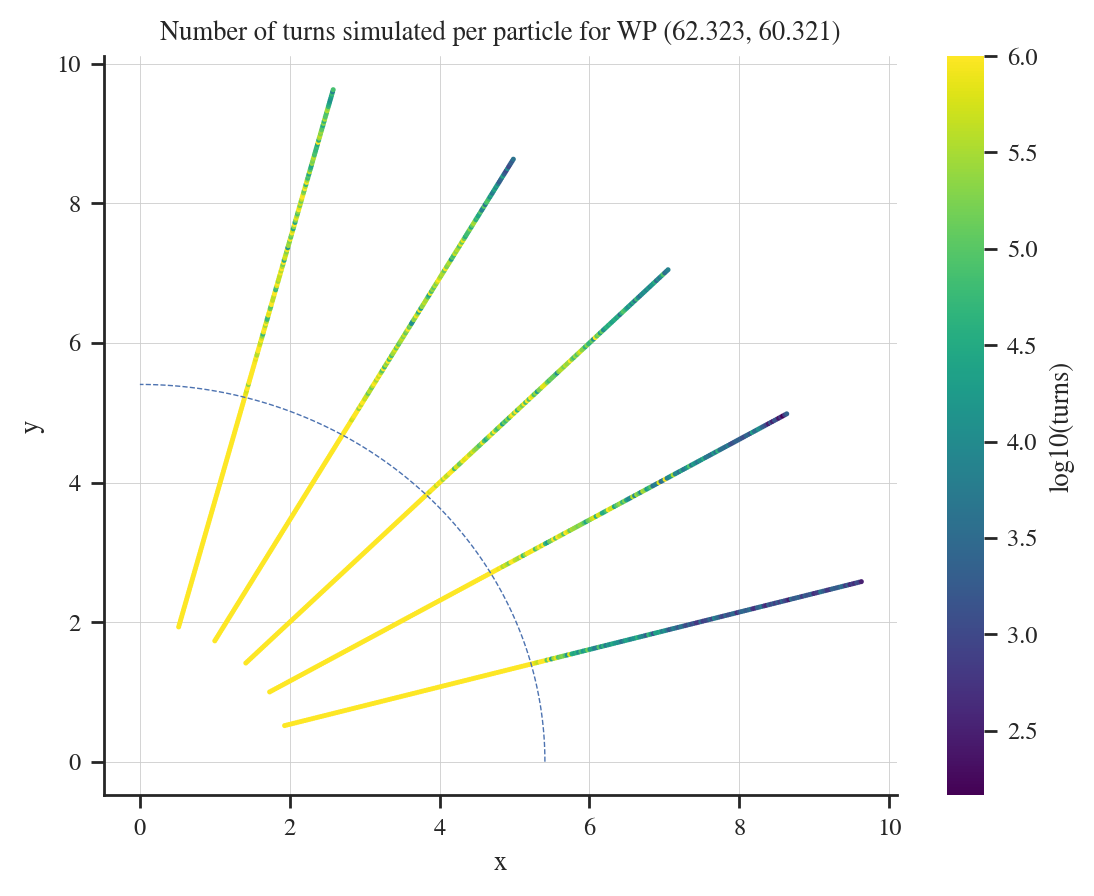

In [6]:
R = df_best["normalized amplitude in xy-plane"]
theta = df_best["angle in xy-plane [deg]"]/360 * 2 * np.pi
turns = np.log10(df_best["at_turn"])
plt.scatter( R * np.cos(theta), R * np.sin(theta), c=turns,  s = 1, cmap="viridis")
# Get minimum amplitude and plot circular arc
R_min = df_best[df_best['state'] == -1]["normalized amplitude in xy-plane"].min()
theta_min = np.linspace(0, np.pi/2, 100)
plt.plot( R_min * np.cos(theta_min), R_min * np.sin(theta_min), "--")
plt.xlabel("x")
plt.ylabel("y")
cb = plt.colorbar(label="log10(turns)")
cb.outline.set_visible(False)
plt.title("Number of turns simulated per particle for WP (62.323, 60.321)")
plt.grid()
plt.show()

Clearly, many particles that are above the final DA are still stimulated for tens or hundreds of thousands of turns, even though they are not actually needed for DA computation. To gain some time, could one periodically check a job to interrupt the simulations of all particles whose amplitude is above one that has already been lost? Would that be worth the trouble?

Things to consider:
1) It seems quite hard to have jobs communicate with each other
2) It seems relatively simple to stop a simulation, check its state, and restart it with some particles removed


Let's adress point 2 considering a homogeneous distribution of particles amplitude, therefore making point 1 less relevant.


We start by defining a function that allows to plot the survival graph above, but considering this time that the simulation has been stopped after a given number of turns.

In [7]:
def filter_simulation_state(df, n_turns):
    # Make a copy and set the number of turns simulated to n_turns
    df_min = df.copy()
    df_min["at_turn"] = df_min["at_turn"].apply(lambda x: np.min((x, n_turns)))
    return df_min


def plot_simulation_state(df, n_turns, WP=(62.323, 60.321), DA=R_min):
    df_min = filter_simulation_state(df, n_turns)

    R = df_min["normalized amplitude in xy-plane"]
    theta = df_min["angle in xy-plane [deg]"] / 360 * 2 * np.pi
    turns = np.log10(df_min["at_turn"])
    plt.scatter(R * np.cos(theta), R * np.sin(theta), c=turns, s = 1, cmap="viridis")
    # Get minimum amplitude and plot circular arc
    theta_min = np.linspace(0, np.pi / 2, 100)
    plt.plot(DA * np.cos(theta_min), DA * np.sin(theta_min), "-")

    l_current_DA = []
    l_angle = [15, 30, 45, 60, 75]
    for angle in l_angle:
        R_min_current = df_min[
            (df_min["state"] == -1)
            & (df_min["at_turn"] < n_turns)
            & (df_min["angle in xy-plane [deg]"] == angle)
        ]["normalized amplitude in xy-plane"].min()
        l_current_DA.append(R_min_current)
        theta_min = np.linspace(0, np.pi / 2, 100)
        plt.plot(
            R_min_current * np.cos(theta_min),
            R_min_current * np.sin(theta_min),
            color="grey",
            linestyle="--",
        )

    plt.clim(2, 6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    cb = plt.colorbar(label="log10(turns)")
    cb.outline.set_visible(False)
    plt.title(f"Turns simulated per particle for WP {WP}. ({n_turns:.0e} turns simulated)")
    plt.grid()
    plt.show()

    return l_current_DA, l_angle

Let's now define several checkpoints all along the simulation, and plot the survival graph for each of them. The solid line arc is the final DA, the dashed arc lines represent the most likely DA at each checkpoint.

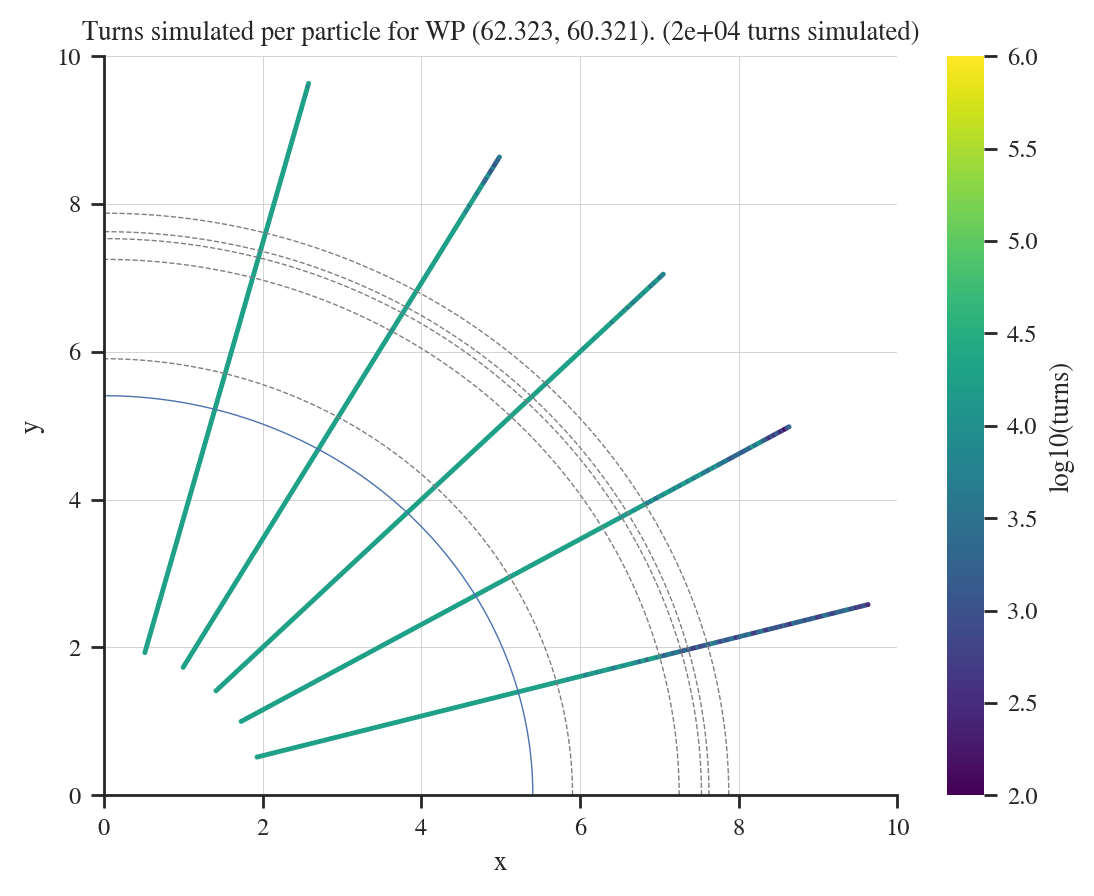

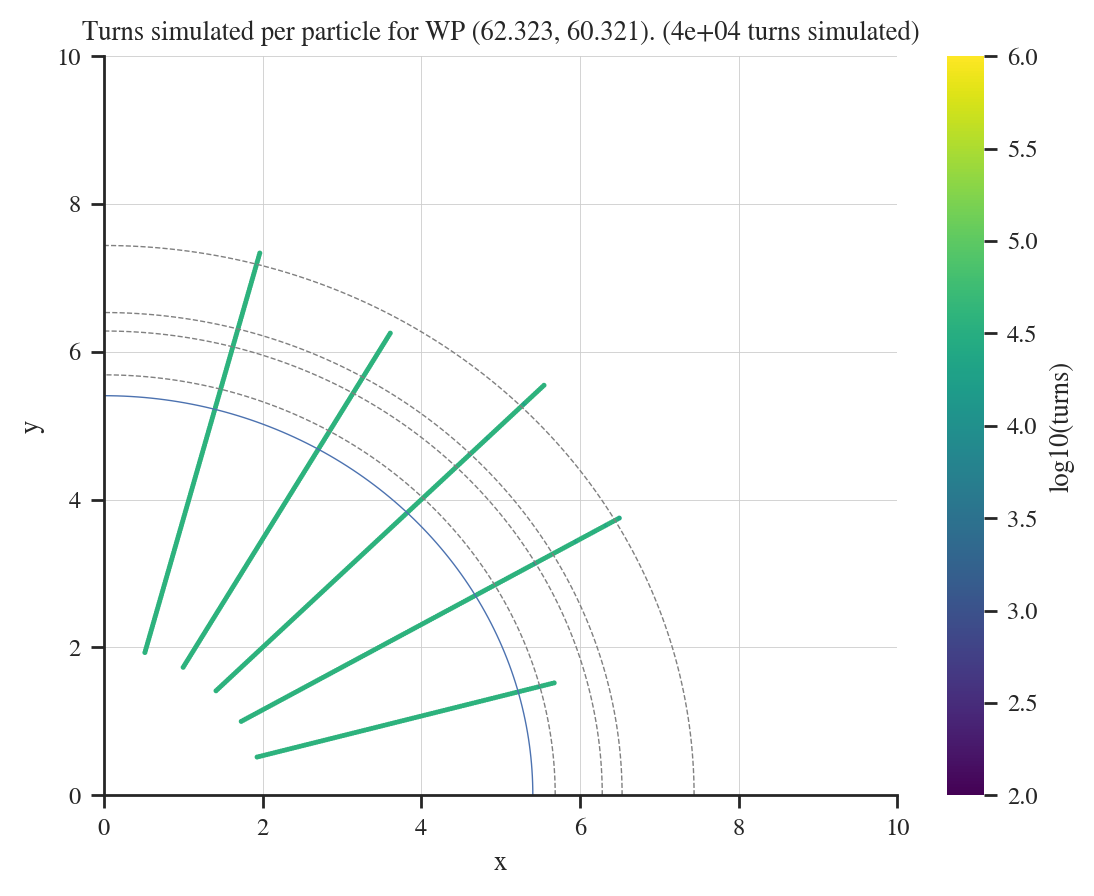

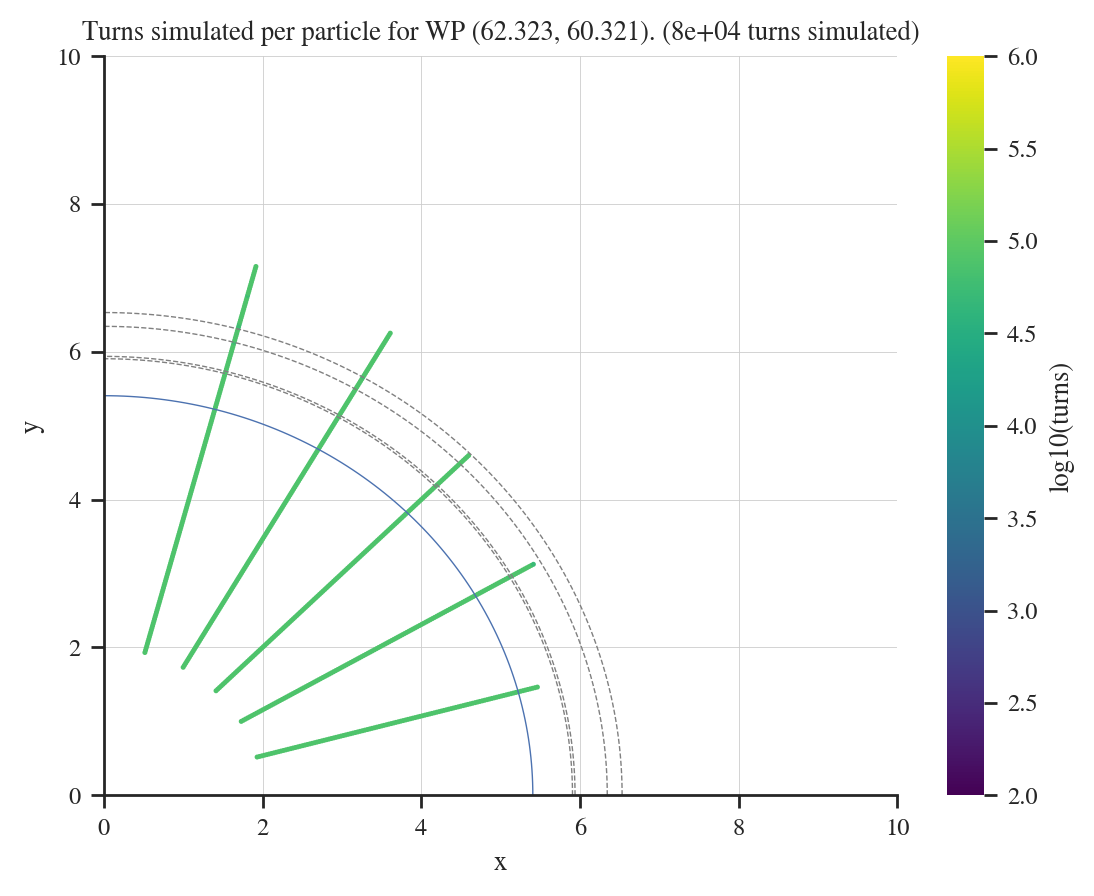

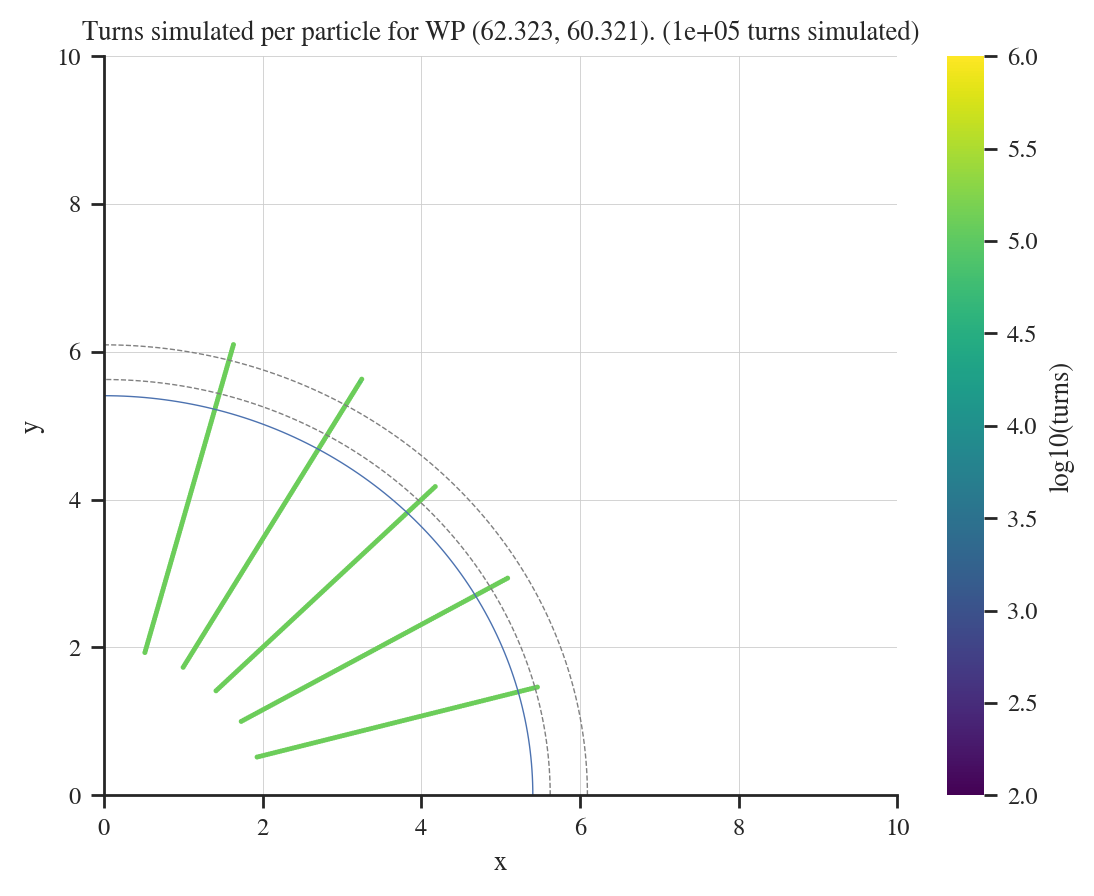

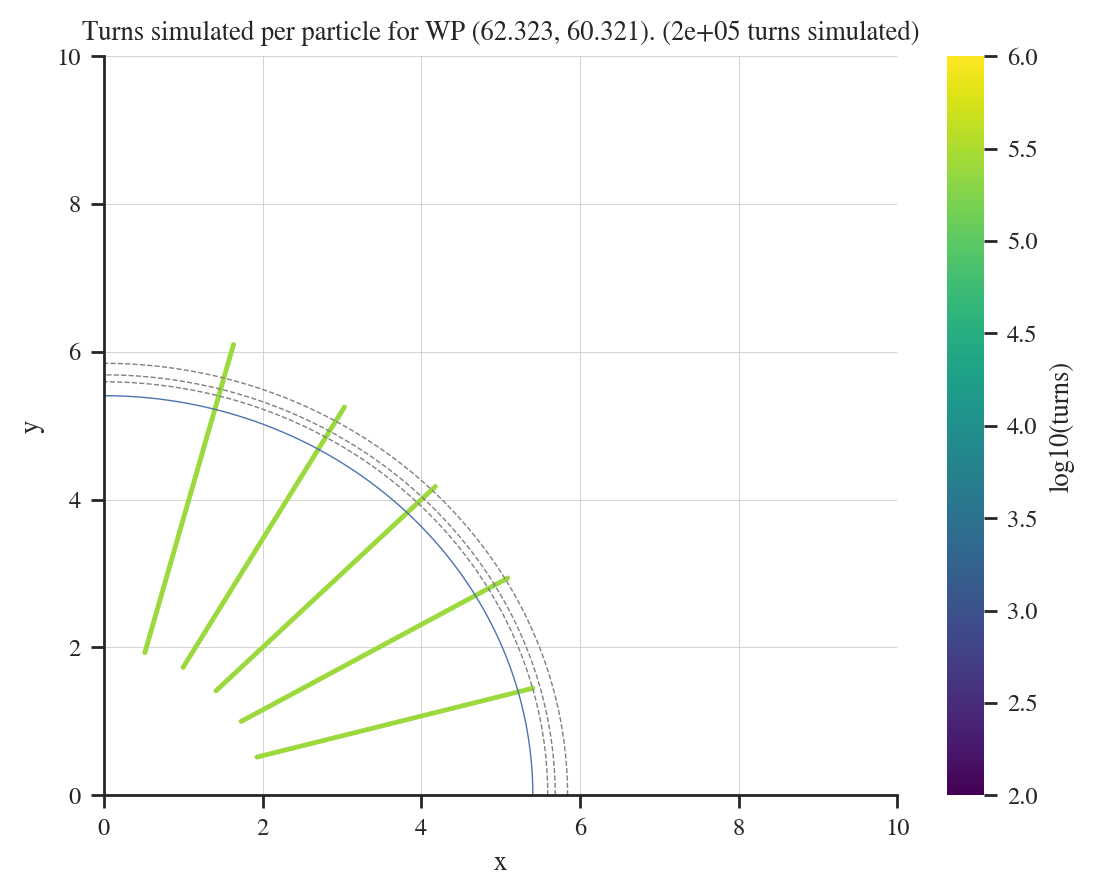

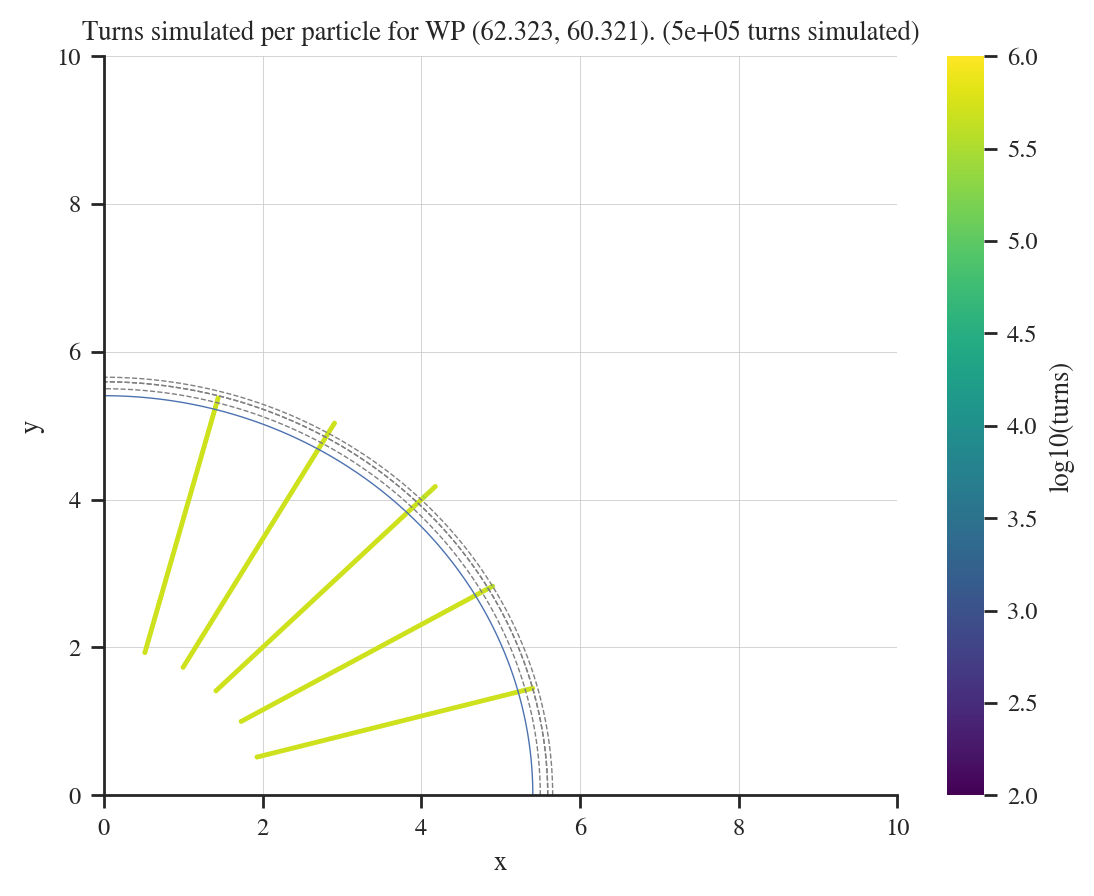

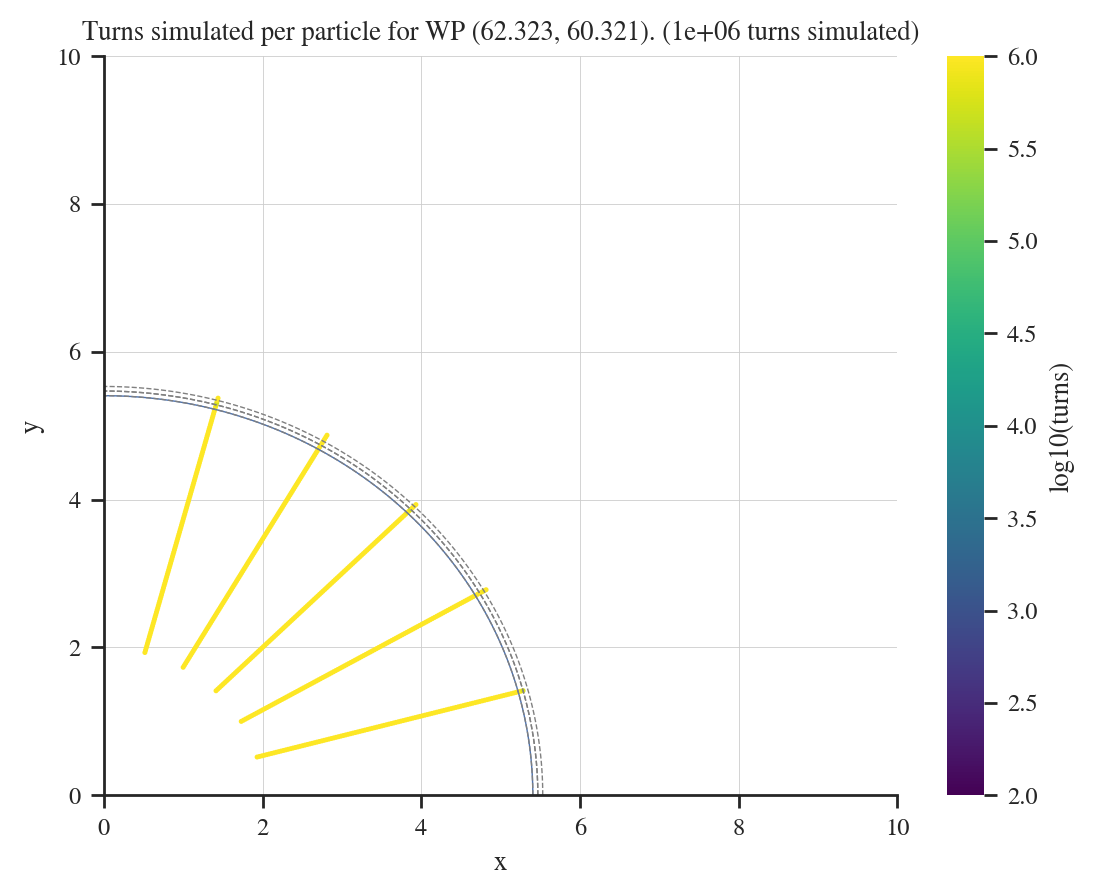

In [8]:
df = df_best.copy()
l_tot_turns_spared = []
l_checkpoints = [18750, 37500, 75000,125000,250000,500000, 1000000]
for n_turns in l_checkpoints:
    # Get current simulation state and plot
    l_current_DA, l_angle = plot_simulation_state(df, n_turns = n_turns, WP = WP)
    # Remove particles that are above particles already lost for each angle
    sub_tot_turns_spared = 0
    for current_DA, angle in zip(l_current_DA, l_angle):
        if not np.isnan(current_DA):
            df_angle = df[df["angle in xy-plane [deg]"] == angle]
            
            # Check how many turns will be spared (not simulated)
            df_removed_particles = df_angle[df_angle["normalized amplitude in xy-plane"] >= current_DA]
            tot_turns_removed = df_removed_particles['at_turn'].sum()
            tot_turns_simulated = df_removed_particles['at_turn'].apply(lambda x: np.min((x, n_turns))).sum()
            sub_tot_turns_spared += tot_turns_removed - tot_turns_simulated
            
            df_angle_filtered = df_angle[df_angle["normalized amplitude in xy-plane"] < current_DA]
            # Merge back into df
            df = pd.concat([df_angle_filtered, df[df["angle in xy-plane [deg]"] != angle]])
            
    l_tot_turns_spared.append(sub_tot_turns_spared)

Let's now see how many turns we can avoid simulating using this method.

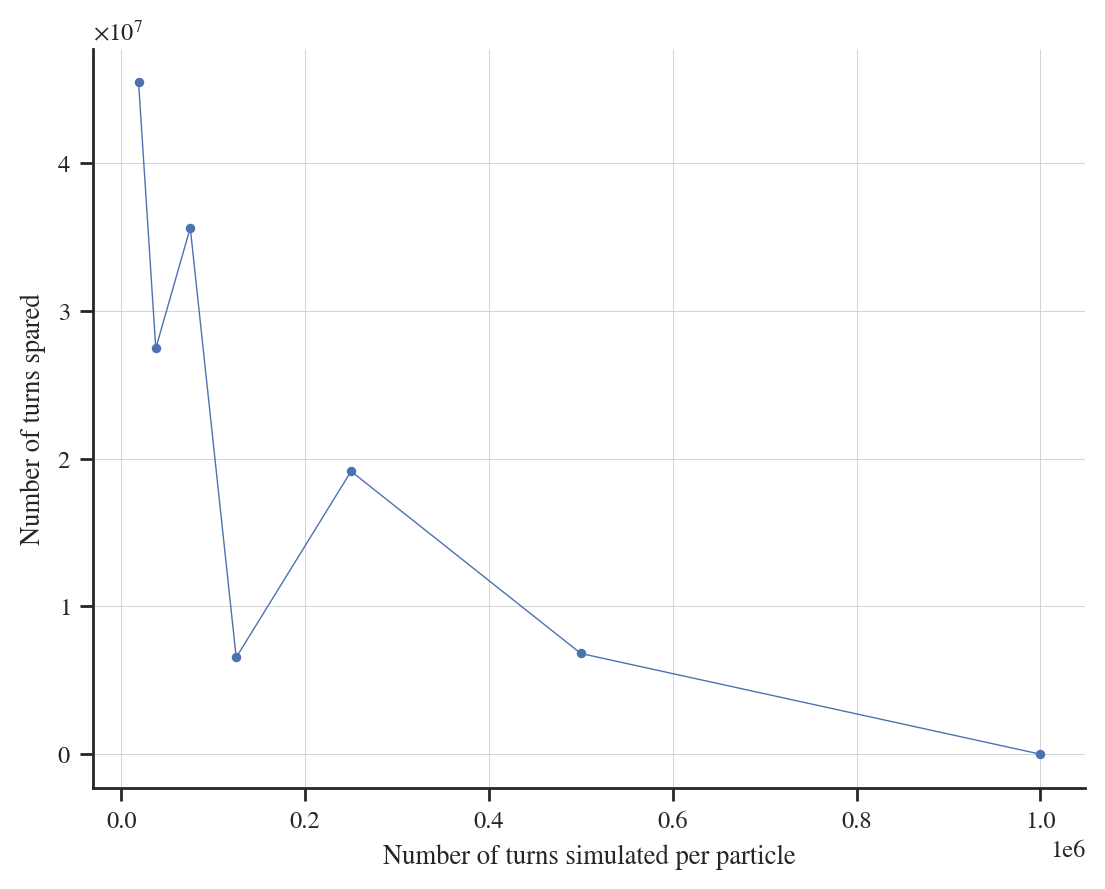

In [9]:
# Comparison of turns simulated with and without periodic checking
fig, ax = plt.subplots()
plt.plot(l_checkpoints, l_tot_turns_spared, ".-")
ax.yaxis.set_major_formatter(formatter) 
#ax.xaxis.set_major_formatter(formatter) 
plt.xlabel('Number of turns simulated per particle')
plt.ylabel('Number of turns spared')
plt.grid()
plt.show()

And as a final check, let's see how the results compare with and without the strategy

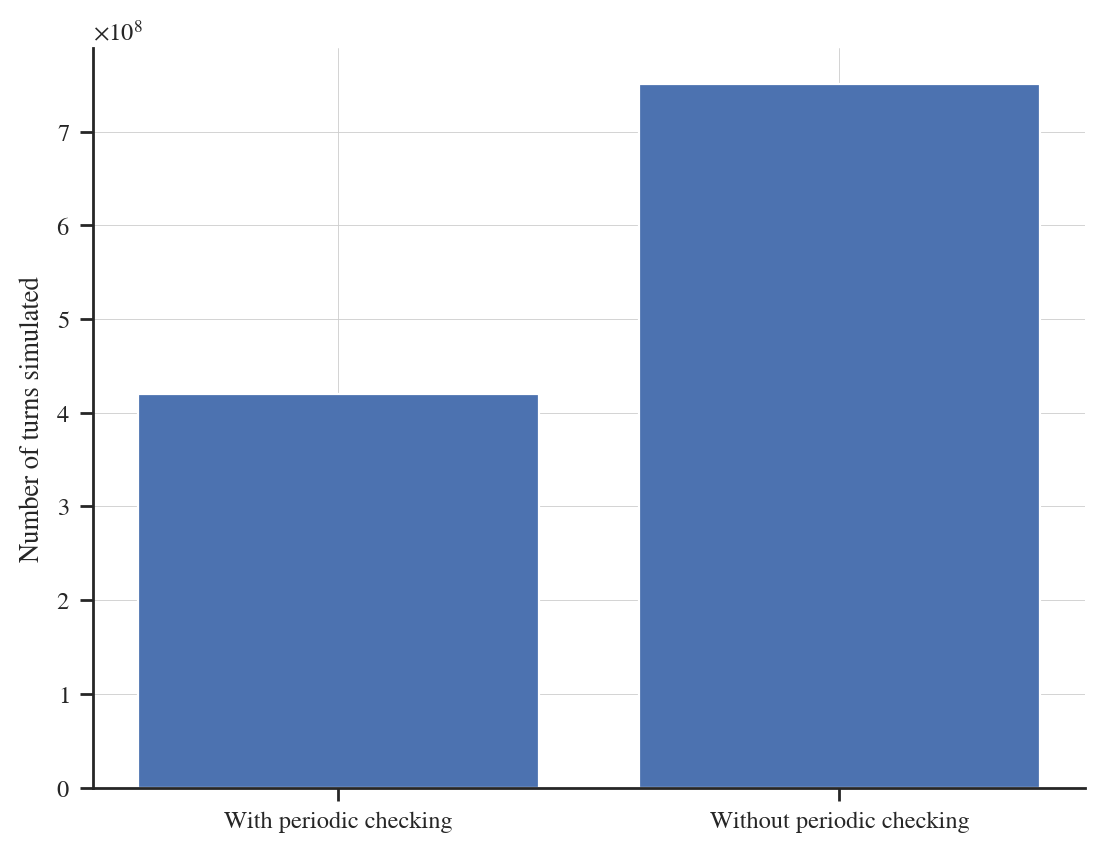

55.89348295204887


In [10]:
# Total number of turns simulated with this strategy vs without
tot_turns = df_best['at_turn'].sum()
tot_turns_with_checkpoints = df['at_turn'].sum() - np.sum(l_tot_turns_spared)
fig, ax = plt.subplots()
plt.bar(["With periodic checking", "Without periodic checking"], [tot_turns_with_checkpoints, tot_turns])
plt.ylabel("Number of turns simulated")
ax.yaxis.set_major_formatter(formatter) 
plt.grid()
plt.show()

print(tot_turns_with_checkpoints/tot_turns*100)

Assuming we can stop a job at pre-specified checkoints, and remove the particles above the current DA, this would mean a gain of about 40% in simulation time (excluding the first 5% to configure the collider), for a WP that has a DA of about 5.5. Of course, bigger gains are expected for lower DA, and conversely.

The main advantage of this method is that it still yields a DA result that is exact, with no uncertainty, while being easy to implement and, a priori, not disturbing the previous simulation workflow.

### Second strategy

Ignoring the first strategy, we normally simulate all particles, at all angles and amplitude, for the maximum number of turns they survive. Yet, in an ideal world, we would first simulate the particles at very low amplitude, check if they all survive, then progressively raise the amplitude until one particle gets lost : the corresponding amplitude would be the DA.

This is not doable as simulating one particle for 1M turns already takes a very long time, and therefore we need to parallelize as much as possible. Yet, we could still be a bit bolder and makes the simulation in several steps: this is the principle of the second strategy.

We first simulate particles of medium to large amplitude (e.g. amplitude between 4.5 and 6.5):
- If they all survive, then most likely we don't need to simulate particles with lower amplitude to find the DA, and can go from e.g 6.5 to 10. 
- Conversely, if none of them survive, we know the DA is lower and we can simulate particles with amplitude between 2 and 4.5.
- If some survive and some don't, then we can either simulate entirely the particles with amplitude between 2 and 4.5 (as in the previous case), but we can be even bolder and assume that if e.g. all particles between 4.5 and 5 have survived, then the DA is most likely already found from the particles lost in the current interval. Therefore, we wouldn't need anymore simulations.

Let's test the gain from this second strategy, assuming that we don't apply the first strategy.
 

We start by plotting the number of turns simulated per particle, depending on its amplitude.

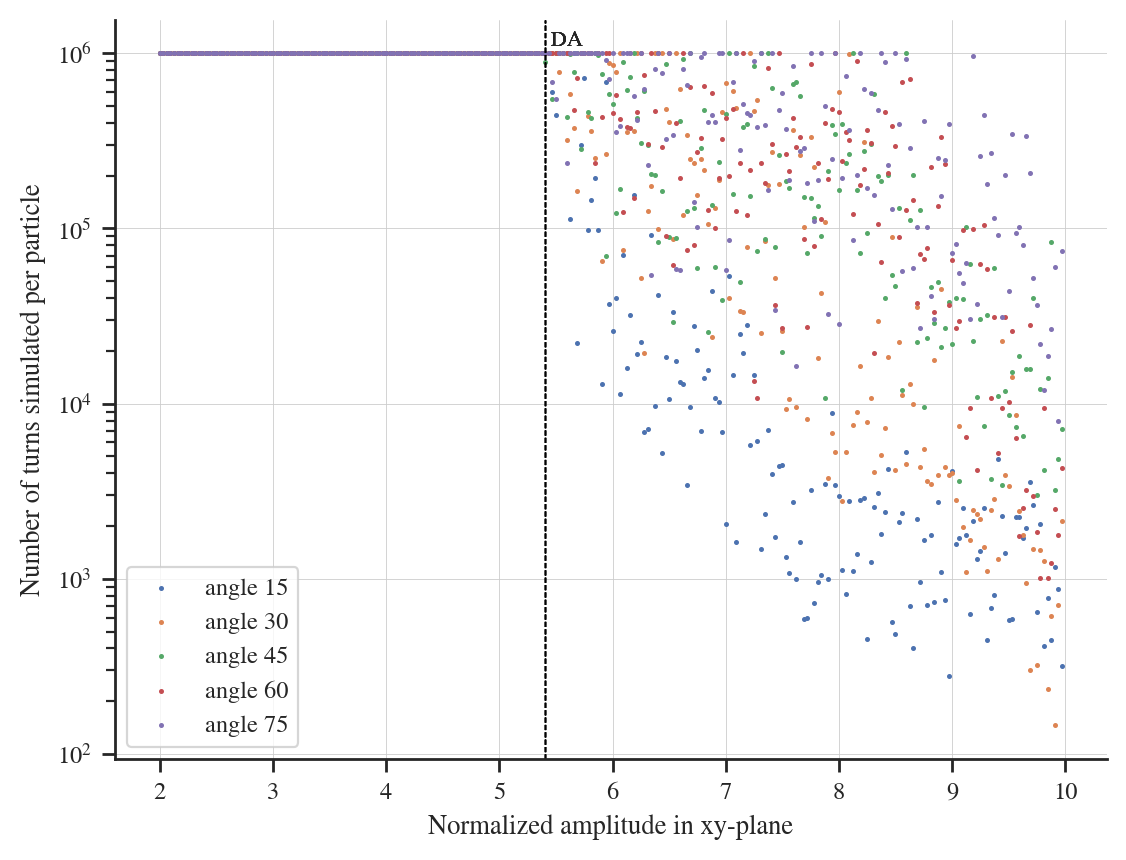

In [11]:
for angle in l_angle:
    df_angle = df_best[df_best["angle in xy-plane [deg]"] == angle]
    plt.scatter(df_angle ['normalized amplitude in xy-plane'], df_angle ['at_turn'], s = 1, label = f"angle {angle}")
    plt.axvline(R_min, color="black", linestyle="--")
    plt.text(R_min, 1.1e6, ' DA', fontsize=8)

    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.xlabel("Normalized amplitude in xy-plane")
    plt.ylabel("Number of turns simulated per particle")

plt.show()

We now assume we only simulate particles with amplitude between 4.5 and 6.5, as a first step.

In [12]:
def plot_survival(df, interval = [4.5, 6.5], DA = None):
    df_angle = df.copy()
    plt.scatter(df_angle['normalized amplitude in xy-plane'], df_angle['at_turn'], s = 1)
    if DA is not None:
        plt.axvline(DA, color="black", linestyle="--")
    # Add transparent rectangle between x = 4.5 and w = 6.5
    plt.axvspan(4.5, 6.5, alpha=0.2, color='grey')
    plt.yscale("log")
    plt.grid()
    plt.xlabel("Normalized amplitude in xy-plane")
    plt.ylabel("Number of turns simulated per particle")
    plt.title(f"Number of turns simulated per particle for WP {WP}")
    plt.show()
    
    half_interval = [interval[0], interval[0] + (interval[1] - interval[0])/2]
    df_half_interval  = df_angle[(df_angle['normalized amplitude in xy-plane'] >= half_interval[0]) & (df_angle['normalized amplitude in xy-plane'] <= half_interval[1])]
    print(f'Percentage of particles surviving in the interval {half_interval}:', len(df_half_interval[df_half_interval['at_turn']==10**6])/len(df_half_interval)*100)

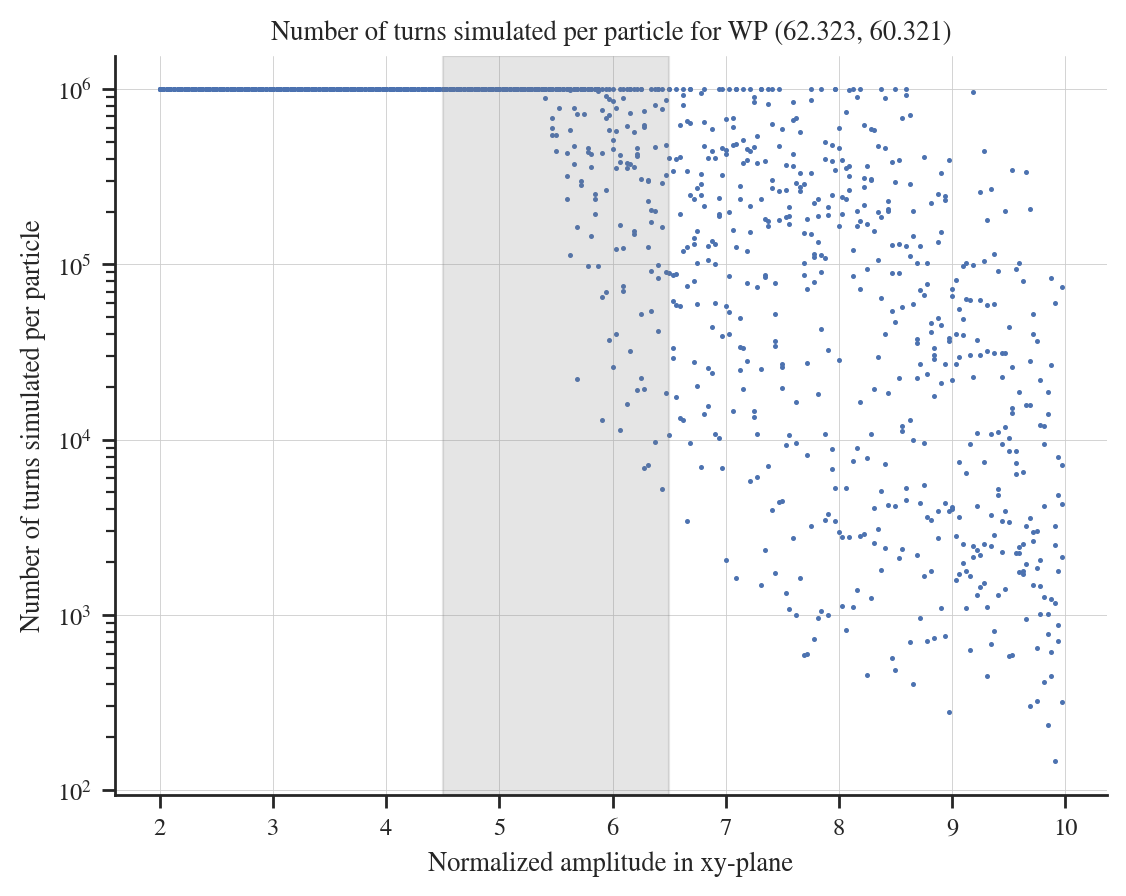

Percentage of particles surviving in the interval [4.5, 5.5]: 96.36363636363636


In [13]:
plot_survival(df_best, interval = [4.5, 6.5])


It doesn't seem risky to assume that if the first half of the interval doesn't contain lost particles, or very few, then the DA must probably correspond to the first particle lost in the interval. To make the rule more systematic, we could consider the percentage of particles surviving in the first half of the interval: if it's higher than e.g. 95%, we assume the DA is already found in the interval.

This assumption must of course be tested, this will be done a bit further in this notebook.

Let's now compute how much time would have been gained with this strategy (scanning all WPs).

In [14]:
def compute_turns(df_init, treshold_mid_case = 0.9):
    l_tot_turns_no_strategy = []
    l_tot_turns_strategy = []
    for qx in np.linspace(62.305, 62.329, 25, endpoint=True):
        for qy in np.linspace(60.305, 60.329, 25, endpoint=True):
            df_best = df_init[(df_init["qx"] == qx) & (df_init["qy"] == qy)]

            if len(df_best) == 0:
                continue
            
            # Remove entries with nan
            df_best = df_best.dropna()

            # Get total number of turns simulated with no strategy
            n_turns_simulated = df_best["at_turn"].sum()
            l_tot_turns_no_strategy.append(n_turns_simulated)

            # Get total number of turns simulated with strategy
            df_curr = df_best.copy()
            df_curr = df_curr[
                (df_curr["normalized amplitude in xy-plane"] >= 4.5)
                & (df_curr["normalized amplitude in xy-plane"] < 6.5)
            ]

            n_turns_simulated_curr = df_curr["at_turn"].sum()

            # All particles survived, need to simulate higher DA
            if len(df_curr[df_curr["state"] == -1]) == len(df_curr):
                df_curr = df_curr[df_curr["normalized amplitude in xy-plane"] >= 6.5]
                n_turns_simulated_curr += df_curr["at_turn"].sum()

            # Zero particles survived, need to simulate lower DA
            elif len(df_curr[df_curr["state"] == -1]) == 0:
                df_curr = df_curr[df_curr["normalized amplitude in xy-plane"] < 4.5]
                n_turns_simulated_curr += df_curr["at_turn"].sum()

            # Else, some particles survived, need to apply finer strategy
            else:
                # Check surval in half interval
                df_curr = df_curr[
                    (df_curr["normalized amplitude in xy-plane"] >= 4.5)
                    & (df_curr["normalized amplitude in xy-plane"] < 5.5)
                ]
                if len(df_curr[df_curr["at_turn"] == 10**6]) / len(df_curr) * 100 >= treshold_mid_case:
                    
                    # All good, turns have already been accounted for, but let's just check that the DA is correct
                    curr_DA = df_curr[df_curr["state"] == -1]["normalized amplitude in xy-plane"].min()
                    # Nan means that no particle failed in the half interval... We take the max just to be sure
                    if np.isnan(curr_DA):
                        curr_DA = np.max(df_curr["normalized amplitude in xy-plane"])
                
                    true_DA = df_best[df_best["state"] == -1]["normalized amplitude in xy-plane"].min()
                    if curr_DA > true_DA:
                        print(f"Warning, DA is not correct. Found {curr_DA} instead of {true_DA}")
                        print(qx, qy, len(df_curr[df_curr["at_turn"] == 10**6]) / len(df_curr) * 100)
                else:
                    # Need to simulate lower DA
                    df_curr = df_curr[df_curr["normalized amplitude in xy-plane"] < 4.5]
                    n_turns_simulated_curr += df_curr["at_turn"].sum()

            l_tot_turns_strategy.append(n_turns_simulated_curr)
    
    return l_tot_turns_no_strategy, l_tot_turns_strategy

In [15]:
l_tot_turns_no_strategy, l_tot_turns_strategy = compute_turns(df_init, treshold_mid_case = 90)

Warning, DA is not correct. Found 4.625 instead of 4.125
62.308 60.318 91.07142857142857
Warning, DA is not correct. Found 4.5 instead of 3.906
62.308 60.319 95.83333333333334
Warning, DA is not correct. Found 4.688 instead of 4.375
62.308 60.322 96.09375
Warning, DA is not correct. Found 4.625 instead of 4.312
62.308 60.323 92.36111111111111
Warning, DA is not correct. Found 5.062 instead of 4.0
62.309 60.313 90.17857142857143
Warning, DA is not correct. Found 4.656 instead of 4.0
62.309 60.314 93.75
Warning, DA is not correct. Found 4.906 instead of 4.125
62.309 60.32 97.32142857142857
Warning, DA is not correct. Found 4.594 instead of 4.094
62.31 60.311 90.97222222222221
Warning, DA is not correct. Found 4.781 instead of 4.281
62.31 60.312 90.17857142857143
Warning, DA is not correct. Found 4.719 instead of 4.25
62.313 60.31 95.83333333333334


Let's check some failed cases

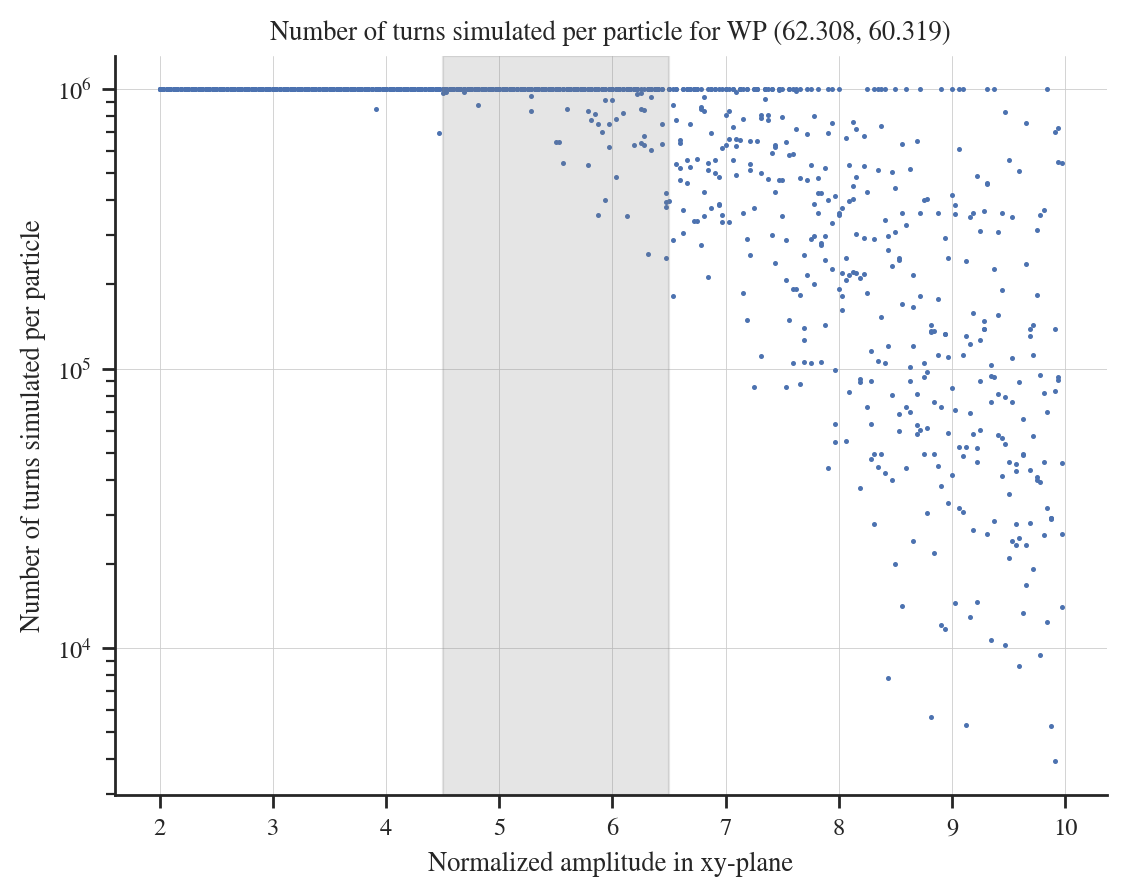

Percentage of particles surviving in the interval [4.5, 5.5]: 95.27027027027027


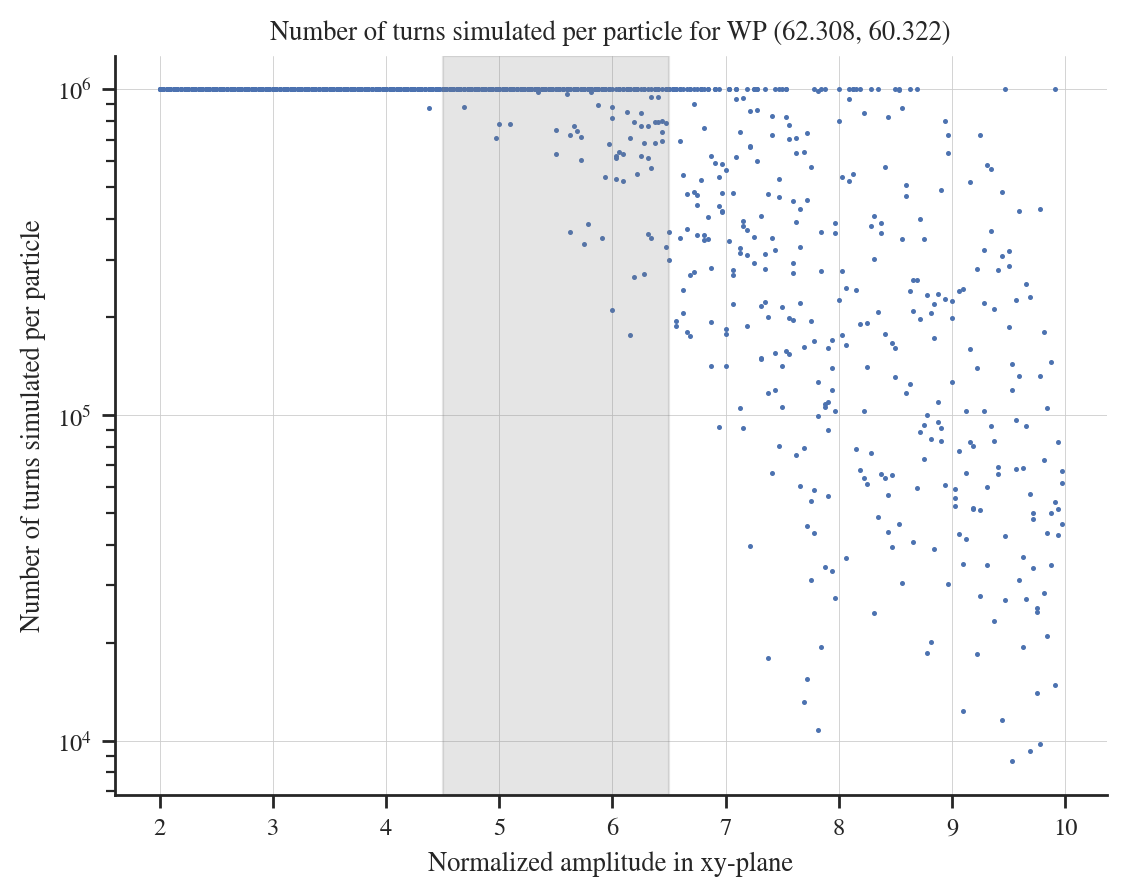

Percentage of particles surviving in the interval [4.5, 5.5]: 94.6969696969697


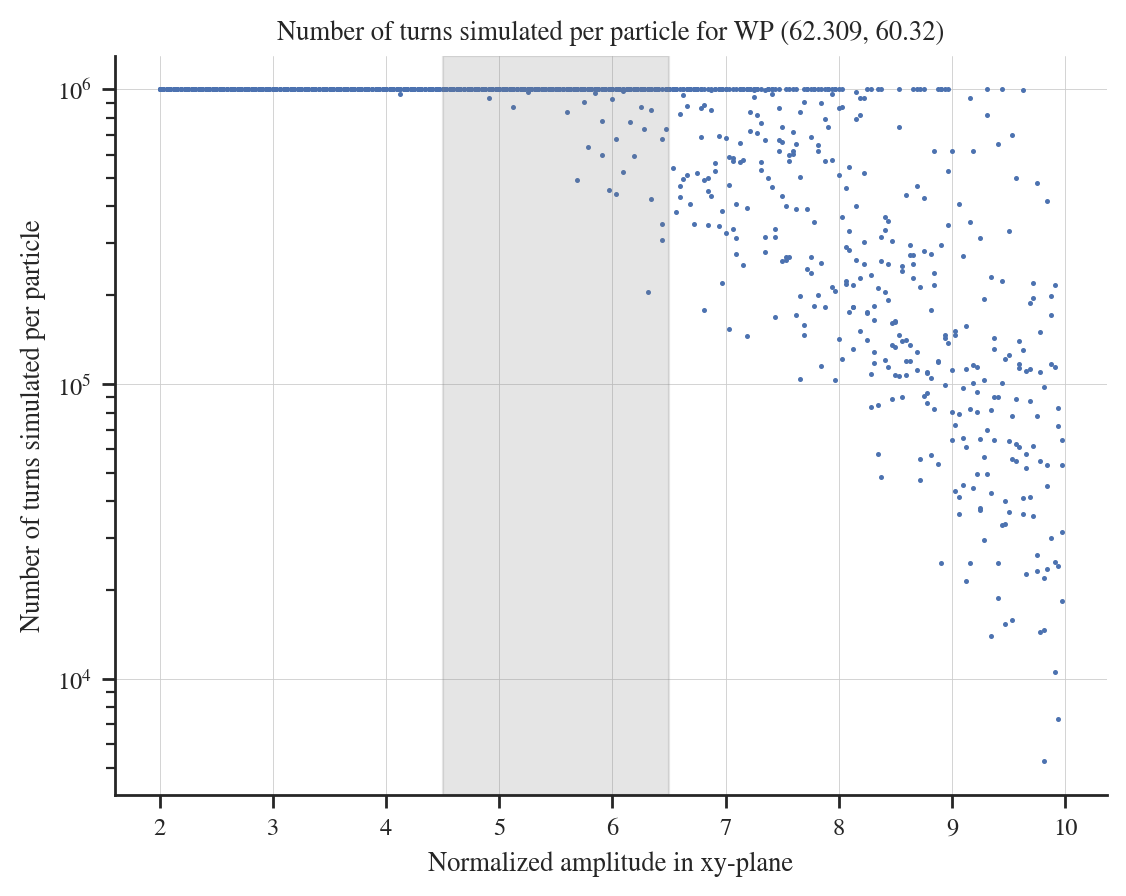

Percentage of particles surviving in the interval [4.5, 5.5]: 97.41379310344827


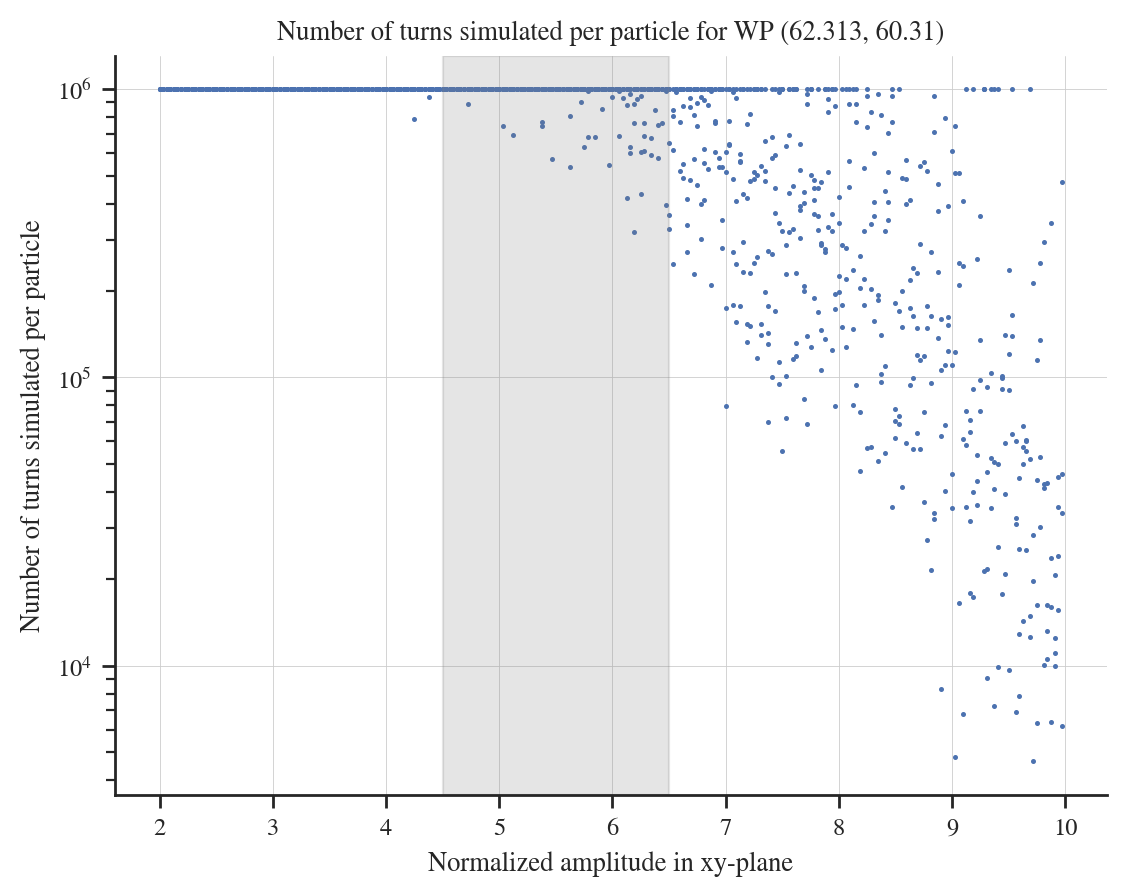

Percentage of particles surviving in the interval [4.5, 5.5]: 95.9731543624161


In [16]:
WP = (62.308, 60.319)
df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]
plot_survival(df_best, interval = [4.5, 6.5])

WP = (62.308, 60.322)
df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]
plot_survival(df_best, interval = [4.5, 6.5])


WP = (62.309, 60.32)
df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]
plot_survival(df_best, interval = [4.5, 6.5])

WP = (62.313, 60.31)
df_best = df_init[(df_init["qx"] == WP[0]) & (df_init["qy"] == WP[1])]
plot_survival(df_best, interval = [4.5, 6.5])


In all of those cases, some particles are lost in the first half of the interval... Let's therefore consider a percentage of 100%, i.e. no particle can be lost in the first half of the integral.

In [17]:
l_tot_turns_no_strategy, l_tot_turns_strategy = compute_turns(df_init, treshold_mid_case = 100)

Let's plot a boxplot representaing the distribution of gain in simulation time for all WPs.

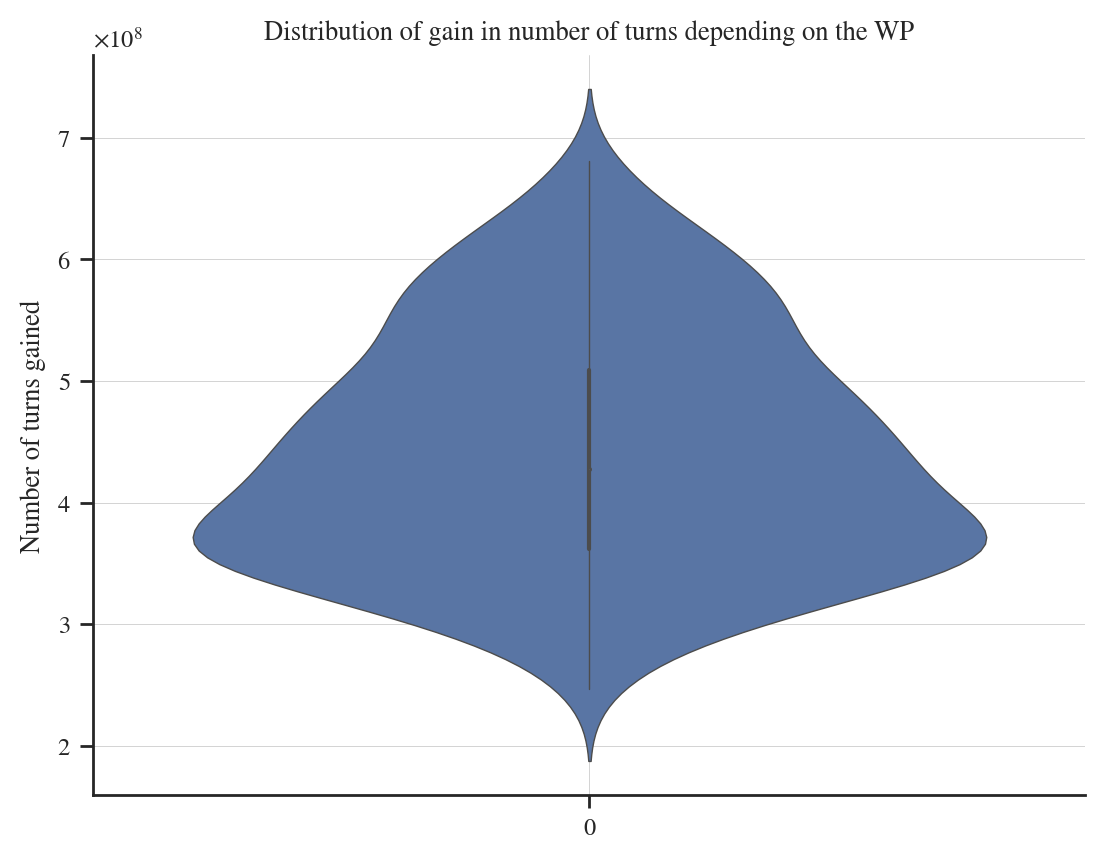

In [18]:
# Comparison of turns simulated with and without speed up strategy, with boxplot
fig, ax = plt.subplots()
sns.violinplot(np.array(l_tot_turns_no_strategy)- np.array(l_tot_turns_strategy))
ax.yaxis.set_major_formatter(formatter) 
plt.grid()
plt.ylabel('Number of turns gained')
plt.title("Distribution of gain in number of turns depending on the WP")
plt.show()


Let's now plot the total simulation gain for all WP

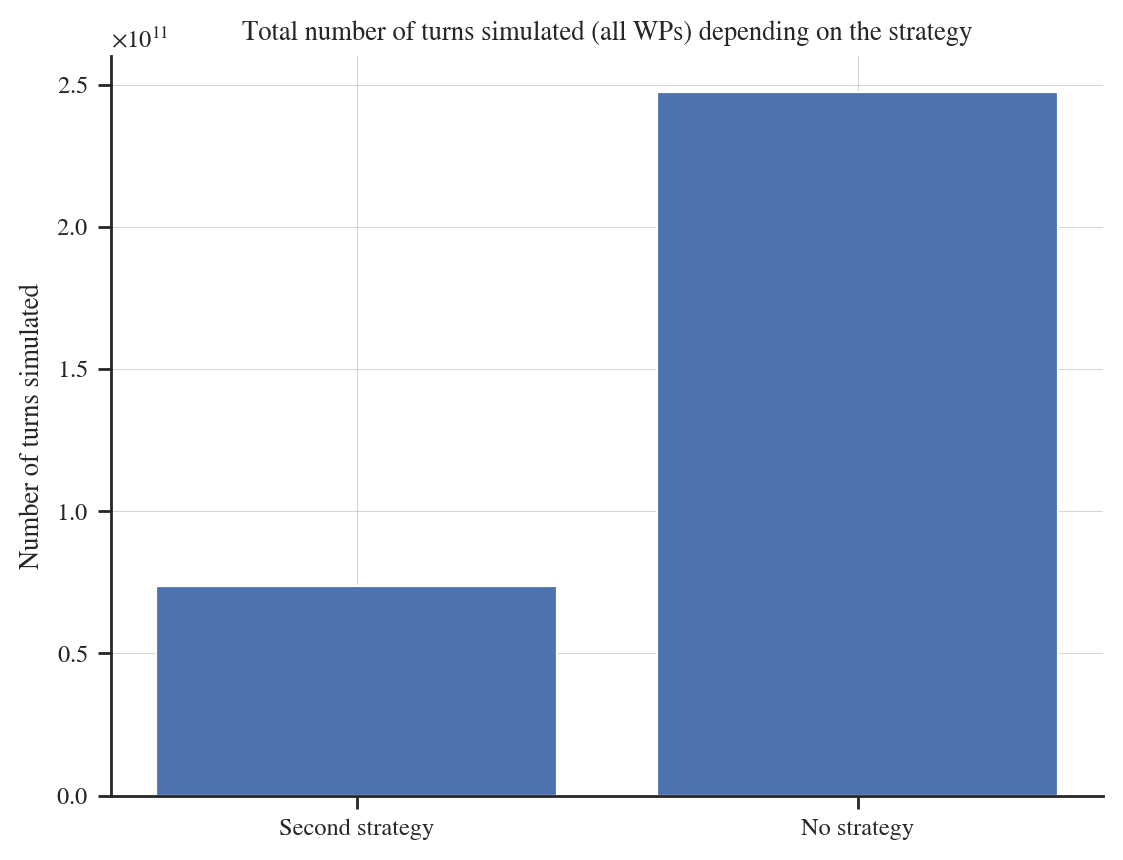

29.80809642476263


In [19]:
fig, ax = plt.subplots()
ax.bar(["Second strategy", "No strategy"], [np.sum(l_tot_turns_strategy), np.sum(l_tot_turns_no_strategy)])
plt.title("Total number of turns simulated (all WPs) depending on the strategy")
ax.yaxis.set_major_formatter(formatter)
plt.ylabel("Number of turns simulated")
plt.grid()
plt.show()

print(np.sum(l_tot_turns_strategy)/np.sum(l_tot_turns_no_strategy)*100)

We gain almost 70% of turns computed! Although not all the jobs are parallelized anymore, so we don't actually gain as much in the end.

### Third strategy

What if we now consider that we simply don't need to compute the DA, or not fully, if we know that it will be very low, and therefore not relevant for the study? The idea is quite simple to implement and could yield a significant gain in simulation time. However, this means that we must be able to somehow predict the DA before actually computing it fully, which is not granted.

Let's start by seeing how the tune-scan heatmap evolves with the number of turns simulated.

### Combining strategies

Combining strategies does not mean cumulating turns gained. Indeed, the first strategy essentially gain time by not simulating the high-amplitude particles when it's not needed, which, in a way, is also what the second strategy does. In addition, the last strategy avoids simulating for too long the WPs that are not relevant, that is, those with low DA, and therefore those for which the first and second strategy would also have yielded a gain in simulation time.

However, using both the first and second strategy, a lot of time is lost computing low-amplitude particles, which are not actually useful to find the DA (with high likelihood, at least). The second strategy allows to mitigate this.

Therefore, the first and last strategy might be the more redundant, and the second strategy the most complementary to the other two. Given that the last strategy is also the one that yields the poorest result (a large portion of the parameter space remains unexplored), it might be worth considering the first and second strategies together.

